In [1]:
import zipfile
with zipfile.ZipFile("/content/drive/My Drive/BienSoXe/Bien_so_xe_full.zip", 'r') as zipObj:
    zipObj.extractall()

In [2]:
import json
with open("/content/drive/My Drive/BienSoXe/data_worked.json") as json_file:
    data=json.load(json_file)

In [3]:
print(len(data))

1495


In [4]:
import numpy as np
x=np.zeros([len(data), 62, 72, 3])
y=np.zeros([len(data), 9, 4])
y_kyTu=np.zeros([len(data), 9, 32])

In [5]:
import cv2
file_path="/content/GreenParking/"
arr_kyTu=['0','1','2','3','4','5','6','7','8','9','A','B','C','D','E','F','G','H','K','L','M','N','P','R','S','T','U','V','X','Y','Z']
for i, f in enumerate(data):
    img=cv2.imread(file_path+"/"+f)
    bienSo=data[f]["bienSo"]
    img_bienSo=img[bienSo['y']:(bienSo['y']+bienSo['h']), bienSo['x']:(bienSo['x']+bienSo['w'])]
    x[i]=cv2.resize(img_bienSo, (72,62))
    for j, kyTu in enumerate(data[f]["kyTu"]):
        y[i][j][0]=kyTu['x']*72/bienSo['w']
        y[i][j][1]=kyTu['y']*62/bienSo['h']
        y[i][j][2]=kyTu['w']*72/bienSo['w']
        y[i][j][3]=kyTu['h']*62/bienSo['h']
        y_kyTu[i][j][arr_kyTu.index(kyTu['kyTu'])]=1
    if (j==7):
        y_kyTu[i][8][31]=1

In [6]:
sum=np.zeros(32)
for i, f in enumerate(data):
    for j, kyTu in enumerate(data[f]["kyTu"]):
        sum+=y_kyTu[i][j]
print(sum)

[ 848. 1789. 1101.  892.  954. 1801.  938.  892.  763. 1531.   19.  134.
  121.   54.   51.  121.   30.  111.   68.  105.   50.   51.  121.   19.
  128.   84.   66.   65.   60.   29.   29.    0.]


In [7]:
x_train=x[:1200]
y_train=y[:1200]
y_kyTu_train=y_kyTu[:1200]
x_test=x[1200:]
y_test=y[1200:]
y_kyTu_test=y_kyTu[1200:]

In [8]:
backgrounds=np.load("/content/drive/My Drive/BienSoXe/backgrounds.npy")

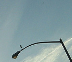

In [9]:
from google.colab.patches import cv2_imshow
img=backgrounds[np.random.randint(backgrounds.shape[2])]
backgrounds_x=np.random.randint(img.shape[1]-72)
backgrounds_y=np.random.randint(img.shape[0]-62)
cv2_imshow(img[backgrounds_y:(backgrounds_y+62), backgrounds_x:(backgrounds_x+72)])

In [10]:
import math
def rotate(img, y):
    if (np.random.randint(2)==0):
        alpha_do=np.random.randint(5, 15)
    else:
        alpha_do=np.random.randint(-15, -5)
    alpha=alpha_do*math.pi/180
    bienSo=y["bienSo"]
    center=(bienSo['x']+bienSo['w']//2, bienSo['y']+bienSo['h']//2)
    M=cv2.getRotationMatrix2D(center, alpha_do, 1) 
    rotated=cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
    wh_bienSo=(bienSo['h']*math.sin(abs(alpha))+bienSo['w']*math.cos(abs(alpha)), bienSo['h']*math.cos(abs(alpha))+bienSo['w']*math.sin(abs(alpha)))
    x_bienSo=center[0]-wh_bienSo[0]//2
    y_bienSo=center[1]-wh_bienSo[1]//2
    if (x_bienSo<0 or y_bienSo<0):
        return trans(img, y)
    img_bienSo=rotated[int(y_bienSo):int(y_bienSo+wh_bienSo[1]), int(x_bienSo):int(x_bienSo+wh_bienSo[0]), :]
    img_bienSo=cv2.resize(img_bienSo, (72,62))
    y_kyTu=np.zeros([9, 4])
    for i, kyTu in enumerate(y["kyTu"]):
        center_kyTu_x=wh_bienSo[0]//2-(kyTu['x']+kyTu['w']//2+bienSo['x']-x_bienSo)
        center_kyTu_y=wh_bienSo[1]//2-(kyTu['y']+kyTu['h']//2+bienSo['y']-y_bienSo)
        center_kyTu_x1=center_kyTu_x*math.cos(alpha)+center_kyTu_y*math.sin(alpha)
        center_kyTu_y1=center_kyTu_y*math.cos(alpha)-center_kyTu_x*math.sin(alpha)

        wi=(kyTu['h']*math.sin(abs(alpha))+kyTu['w']*math.cos(abs(alpha)))*72/wh_bienSo[0]
        hi=(kyTu['w']*math.sin(abs(alpha))+kyTu['h']*math.cos(abs(alpha)))*62/wh_bienSo[1]
        xi=(wh_bienSo[0]//2-center_kyTu_x1)*72/wh_bienSo[0]-wi//2
        yi=(wh_bienSo[1]//2-center_kyTu_y1)*62/wh_bienSo[1]-hi//2
        y_kyTu[i]=[xi, yi, wi, hi]
    return [img_bienSo, y_kyTu]
def trans(img, y):
    mode=np.random.randint(2)
    bienSo=y["bienSo"]
    rand_x1=0
    rand_y1=0
    rand_x2=0
    rand_y2=0
    if (mode==0):
        if (bienSo['x']>0):
            rand_x1=np.random.randint(min(20, bienSo['x']))
        if (bienSo['y']>0):
            rand_y1=np.random.randint(min(20, bienSo['y']))
        rand_x2=np.random.randint(min(20, 472-bienSo['x']-bienSo['w']))
        rand_y2=np.random.randint(min(20, 303-bienSo['y']-bienSo['h']))
    else:
        if (bienSo['y']>0):
            rand_y1=min(np.random.randint(20, 60), bienSo['y'])
        rand_y2=min(303-bienSo['y']-bienSo['h'], np.random.randint(20, 60))
    img_bienSo=img[(bienSo['y']-rand_y1):(bienSo['y']+bienSo['h']+rand_y2), (bienSo['x']-rand_x1):(bienSo['x']+bienSo['w']+rand_x2)]
    img_bienSo=cv2.resize(img_bienSo, (72,62))
    y_kyTu=np.zeros([9, 4])
    for i, kyTu in enumerate(y["kyTu"]):
        xi=(kyTu['x']+rand_x1)*72/(bienSo['w']+rand_x1+rand_x2)
        yi=(kyTu['y']+rand_y1)*62/(bienSo['h']+rand_y1+rand_y2)
        wi=kyTu['w']*72/(bienSo['w']+rand_x1+rand_x2)
        hi=kyTu['h']*62/(bienSo['h']+rand_y1+rand_y2)
        y_kyTu[i]=[xi, yi, wi, hi]
    return [img_bienSo, y_kyTu]
def brightness(x):
    value=np.random.randint(-50, 50)
    x=cv2.cvtColor(x, cv2.COLOR_BGR2HSV)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            temp=x[i,j,2]+value
            if (temp>255): x[i,j,2]=255
            elif (temp<0): x[i,j,2]=0
            else: x[i,j,2]=temp
    x=cv2.cvtColor(x, cv2.COLOR_HSV2BGR)
    return x
def augmentation(data):
    x_aug=np.zeros([len(data), 62, 72, 3])
    y_aug=np.zeros([len(data), 9, 4])
    for i, f in enumerate(data):
        img=cv2.imread(file_path+"/"+f)
        if (np.random.randint(2)==0):
            img_bienSo, rect=trans(img, data[f])
        else:
            img_bienSo, rect=rotate(img, data[f])
        img_bienSo=brightness(img_bienSo)
        x_aug[i]=img_bienSo
        y_aug[i]=rect
    return x_aug, y_aug

x_aug, y_aug=augmentation(data)
x_train=np.concatenate((x_train, x_aug[:1200]), axis=0)
y_train=np.concatenate((y_train, y_aug[:1200]), axis=0)
x_test=np.concatenate((x_test, x_aug[1200:]), axis=0)
y_test=np.concatenate((y_test, y_aug[1200:]), axis=0)

x_aug, y_aug=augmentation(data)
x_train=np.concatenate((x_train, x_aug[:1200]), axis=0)
y_train=np.concatenate((y_train, y_aug[:1200]), axis=0)
x_test=np.concatenate((x_test, x_aug[1200:]), axis=0)
y_test=np.concatenate((y_test, y_aug[1200:]), axis=0)

x_aug, y_aug=augmentation(data)
x_train=np.concatenate((x_train, x_aug[:1200]), axis=0)
y_train=np.concatenate((y_train, y_aug[:1200]), axis=0)
x_test=np.concatenate((x_test, x_aug[1200:]), axis=0)
y_test=np.concatenate((y_test, y_aug[1200:]), axis=0)

x_aug, y_aug=augmentation(data)
x_train=np.concatenate((x_train, x_aug[:1200]), axis=0)
y_train=np.concatenate((y_train, y_aug[:1200]), axis=0)
x_test=np.concatenate((x_test, x_aug[1200:]), axis=0)
y_test=np.concatenate((y_test, y_aug[1200:]), axis=0)

x_aug, y_aug=augmentation(data)
x_train=np.concatenate((x_train, x_aug[:1200]), axis=0)
y_train=np.concatenate((y_train, y_aug[:1200]), axis=0)
x_test=np.concatenate((x_test, x_aug[1200:]), axis=0)
y_test=np.concatenate((y_test, y_aug[1200:]), axis=0)

y_kyTu_train=np.concatenate((y_kyTu_train, y_kyTu_train, y_kyTu_train, y_kyTu_train, y_kyTu_train, y_kyTu_train), axis=0)
y_kyTu_test=np.concatenate((y_kyTu_test, y_kyTu_test, y_kyTu_test, y_kyTu_test, y_kyTu_test, y_kyTu_test), axis=0)

In [11]:
x_fake=np.zeros([1000, 62, 72, 3])
y_fake=np.zeros([1000, 9, 4])
y_kyTu_fake=np.zeros([1000, 9, 32])
for i in range(1000):
    img=backgrounds[np.random.randint(backgrounds.shape[0])]
    backgrounds_x=np.random.randint(img.shape[1]-72)
    backgrounds_y=np.random.randint(img.shape[0]-62)
    x_fake[i]=img[backgrounds_y:(backgrounds_y+62), backgrounds_x:(backgrounds_x+72)]
y_kyTu_fake[:, :, 31]=1

In [12]:
x_train=np.concatenate((x_train, x_fake[:800]), axis=0)
y_train=np.concatenate((y_train, y_fake[:800]), axis=0)
x_test=np.concatenate((x_test, x_fake[800:]), axis=0)
y_test=np.concatenate((y_test, y_fake[800:]), axis=0)

y_kyTu_train=np.concatenate((y_kyTu_train, y_kyTu_fake[:800]), axis=0)
y_kyTu_test=np.concatenate((y_kyTu_test, y_kyTu_fake[800:]), axis=0)

In [13]:
print(x_train.shape)
print(y_train.shape)
print(y_kyTu_train.shape)
print(x_test.shape)
print(y_test.shape)
print(y_kyTu_test.shape)

(8000, 62, 72, 3)
(8000, 9, 4)
(8000, 9, 32)
(1970, 62, 72, 3)
(1970, 9, 4)
(1970, 9, 32)


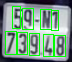

In [14]:
import copy
rand=np.random.randint(x_train.shape[0])
img=copy.copy(x_train[rand])
for kyTu in y_train[rand]:
    cv2.rectangle(img, (int(kyTu[0]), int(kyTu[1])), 
                  (int(kyTu[0]+kyTu[2]), int(kyTu[1]+kyTu[3])), (0, 255, 0), 1)
cv2_imshow(img)

In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, concatenate
from tensorflow.keras.layers import Dropout, BatchNormalization, Reshape, Input, Activation
import tensorflow as tf
def cnn_model(input_shape):
    start_neurals=8
    input=Input(shape=input_shape)

    x1=Conv2D(start_neurals, (3,3), activation='relu', padding='same')(input)
    x1=BatchNormalization()(x1)
    x1=MaxPooling2D((2,2))(x1)
    x1=Dropout(0.2)(x1)

    x1=Conv2D(start_neurals*2, (3,3), activation='relu', padding='same')(x1)
    x1=BatchNormalization()(x1)
    x1=MaxPooling2D((2,2))(x1)
    x1=Dropout(0.2)(x1)

    x1=Conv2D(start_neurals*4, (3,3), activation='relu', padding='same')(x1)
    x1=BatchNormalization()(x1)
    x1=MaxPooling2D((2,2))(x1)
    x1=Dropout(0.2)(x1)

    x1=Conv2D(start_neurals*8, (3,3), activation='relu', padding='same')(x1)
    x1=BatchNormalization()(x1)
    x1=MaxPooling2D((2,2))(x1)
    x1=Dropout(0.2)(x1)

    x2=Conv2D(start_neurals*16, (3,3), activation='relu', padding='same')(x1)
    x2=BatchNormalization()(x2)
    x2=MaxPooling2D((2,2))(x2)
    x2=Dropout(0.2)(x2)

    x2=Flatten()(x2)
    x2=Dense(9*4, activation='relu')(x2)
    x2=Reshape([9,4], name="location_output")(x2)

    x3=Conv2D(start_neurals*16, (3,3), activation='relu', padding='same')(x1)
    x3=BatchNormalization()(x3)
    x3=MaxPooling2D((2,2))(x3)
    x3=Dropout(0.5)(x3)

    x3=Flatten()(x3)
    x3=Dense(9*32, activation='relu')(x3)
    x3=Activation('softmax')(x3)
    x3=Reshape([9,32], name="char_output")(x3)

    model=Model(inputs=input, outputs=[x2, x3])

    losses={"location_output": 'mse', "char_output": tf.keras.losses.binary_crossentropy}
    lossWeights={"location_output": 1.0, "char_output": 1000.0}
    model.compile(loss=losses, optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'], loss_weights=lossWeights)
    return model

In [16]:
model=cnn_model((62,72,3))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 62, 72, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 62, 72, 8)    224         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 62, 72, 8)    32          conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 31, 36, 8)    0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [17]:
model.load_weights("/content/drive/My Drive/BienSoXe/weight_detect_kytu_1.h5")

In [18]:
# import datetime
# log_dir = "/content/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
# model.fit(x_train, 
#           {"location_output": y_train, "char_output": y_kyTu_train}, 
#           batch_size=1024, 
#           epochs=500, 
#           validation_data=(x_test, {"location_output": y_test, "char_output": y_kyTu_test}),
#           callbacks=[tensorboard_callback])

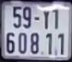

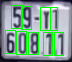

59T160811


In [127]:
rand=np.random.randint(1200, x.shape[0])
img=copy.copy(x[rand])
reshaped=np.reshape(img, (1,img.shape[0], img.shape[1], img.shape[2]))
predict=model.predict(reshaped)
cv2_imshow(img)
for kyTu in predict[0][0]:
    if (kyTu[2]>0):
        cv2.rectangle(img, (int(kyTu[0]), int(kyTu[1])), 
                    (int(kyTu[0]+kyTu[2]), int(kyTu[1]+kyTu[3])), (0, 255, 0), 1)
cv2_imshow(img)
array=""
for i, kyTu in enumerate(predict[1][0]):
    if (np.argmax(kyTu)!=31):
        array+=arr_kyTu[np.argmax(kyTu)]
print(array)
#print(predict[1][0])

In [20]:
#model.save_weights("/content/drive/My Drive/BienSoXe/weight_detect_kytu_1.h5")

In [21]:
# model_json = model.to_json()
# with open("/content/drive/My Drive/BienSoXe/model_detect_kytu_1.json", "w") as json_file:
#     json_file.write(model_json)